In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [29]:
df = pd.read_csv('Phishing Websites Engineered.csv')

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
def canopy_clustering(X, t1, t2):
    points = list(range(X.shape[1]))
    canopies = []
    while points:
        center = points[0]
        center_vector = X.iloc[:, center].values.reshape(-1, 1)
        distances = np.linalg.norm(X.values - center_vector, axis=0)
        canopy = [p for p in points if distances[p] <= t1]
        points = [p for p in points if distances[p] > t2]
        canopies.append(canopy)

    return canopies

In [31]:
t1 = 2.0
t2 = 1.0
canopies = canopy_clustering(X, t1, t2)

In [32]:
selected_features = [canopy[0] for canopy in canopies]
X_selected = X.iloc[:, selected_features]
print("Selected features:", X.columns[selected_features].tolist())

Selected features: ['having_ip_address', 'url_length', 'shortining_service', 'having_at_symbol', 'double_slash_redirecting', 'prefix_suffix', 'having_sub_domain', 'sslfinal_state', 'domain_registration_length', 'favicon', 'port', 'https_token', 'request_url', 'url_of_anchor', 'links_in_tags', 'sfh', 'submitting_to_email', 'abnormal_url', 'redirect', 'on_mouseover', 'rightclick', 'popupwindow', 'iframe', 'age_of_domain', 'dnsrecord', 'web_traffic', 'page_rank', 'google_index', 'links_pointing_to_page', 'statistical_report', 'total_link_flags', 'security_score', 'obfuscation_score', 'tech_complexity']


In [33]:
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],
    'max_iter': [1000],
    'solver': ['lbfgs', 'liblinear']
}
param_grid_svc = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
param_grid_dt = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [34]:
lr_grid = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='accuracy')
svc_grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svc, cv=5, scoring='accuracy')
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')

In [35]:
print("Fitting Logistic Regression...")
lr_grid.fit(X_train, y_train)
print("Fitting SVC...")
svc_grid.fit(X_train, y_train)
print("Fitting Decision Tree...")
dt_grid.fit(X_train, y_train)

Fitting Logistic Regression...
Fitting SVC...
Fitting Decision Tree...


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [36]:
soft_voting = VotingClassifier(
    estimators=[
        ('lr', lr_grid.best_estimator_),
        ('svc', svc_grid.best_estimator_),
        ('dt', dt_grid.best_estimator_)
    ],
    voting='soft'
)

In [37]:
cv_scores = cross_val_score(soft_voting, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())


Cross-validation scores: [0.94337607 0.93589744 0.94017094 0.93376068 0.94224599]
Mean CV score: 0.9390902235019883
Standard deviation: 0.0036903430503798236


In [38]:
soft_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42)),
                             ('svc',
                              SVC(C=10.0, probability=True, random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=7,
                                                     random_state=42))],
                 voting='soft')

In [39]:
y_pred = soft_voting.predict(X_test)

In [40]:
print("\nBest parameters for each model:")
print("Logistic Regression:", lr_grid.best_params_)
print("SVC:", svc_grid.best_params_)
print("Decision Tree:", dt_grid.best_params_)


Best parameters for each model:
Logistic Regression: {'C': 0.1, 'max_iter': 1000, 'solver': 'lbfgs'}
SVC: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Decision Tree: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [41]:
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.9444444444444444

Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.94      0.95       620
           1       0.93      0.95      0.94       550

    accuracy                           0.94      1170
   macro avg       0.94      0.94      0.94      1170
weighted avg       0.94      0.94      0.94      1170



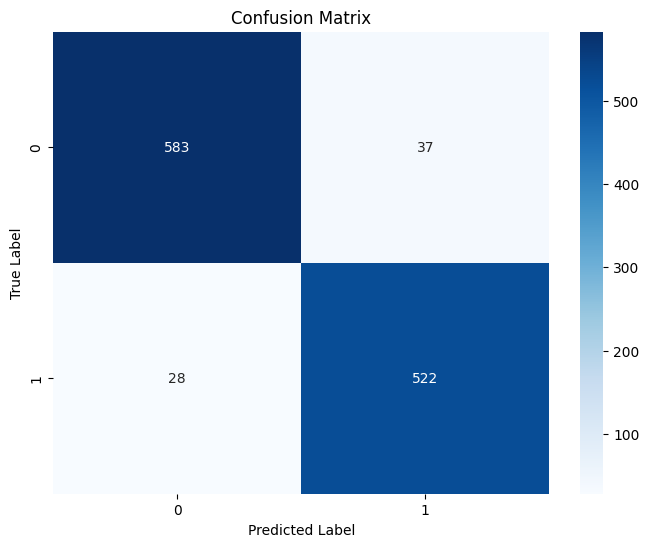

In [42]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **SHAP**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/va

SHAP Summary Plot - LSD Soft Voting Classifier


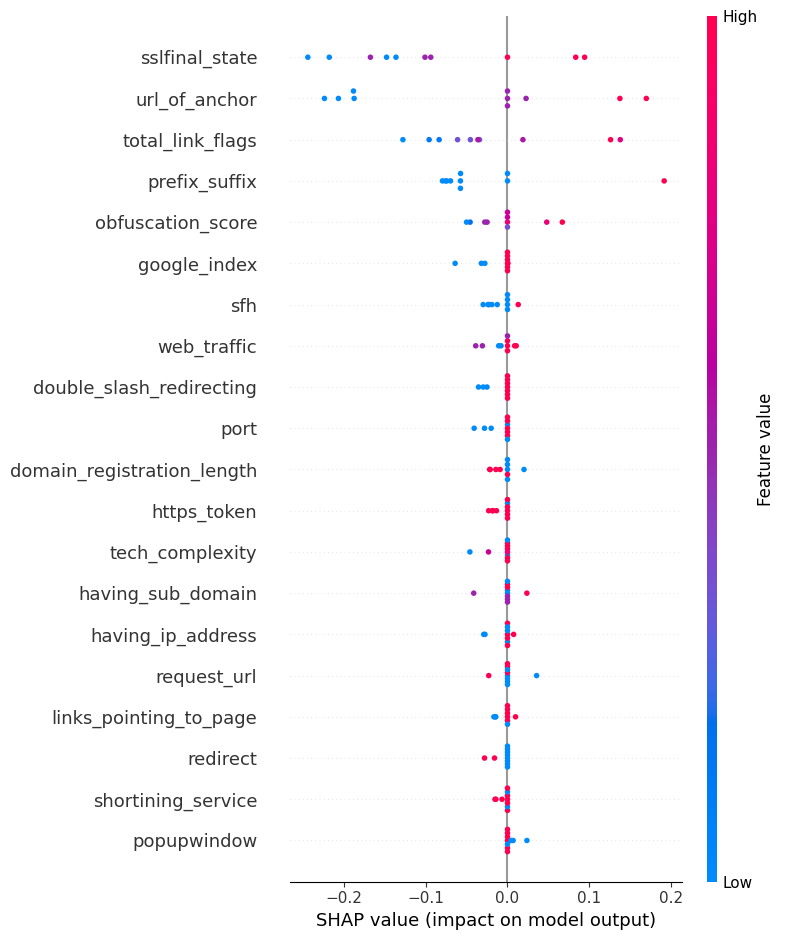

In [43]:
import shap

background = shap.sample(X_train, 100, random_state=42)
voting_explainer = shap.KernelExplainer(soft_voting.predict_proba, background)
sample = X_test.sample(10, random_state=42)
voting_shap_values = voting_explainer.shap_values(sample)

if isinstance(voting_shap_values, list):
    voting_shap_values = voting_shap_values[1]
elif len(voting_shap_values.shape) == 3:
    voting_shap_values = voting_shap_values[:, :, 1]

print("SHAP Summary Plot - LSD Soft Voting Classifier")
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else None
shap.summary_plot(voting_shap_values, sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

# **LIME**

In [44]:
!pip install lime

In [45]:
import lime
import lime.lime_tabular
import numpy as np

In [46]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values if isinstance(X_train, pd.DataFrame) else X_train,
    feature_names=X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature_{i}" for i in range(X_train.shape[1])],
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)


🔍 LIME Explanations - LSD Soft Voting Classifier


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



LIME Explanation for instance 4671:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


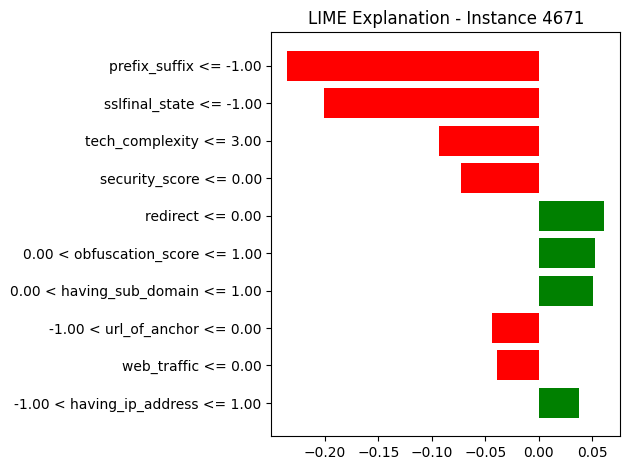

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



LIME Explanation for instance 1871:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


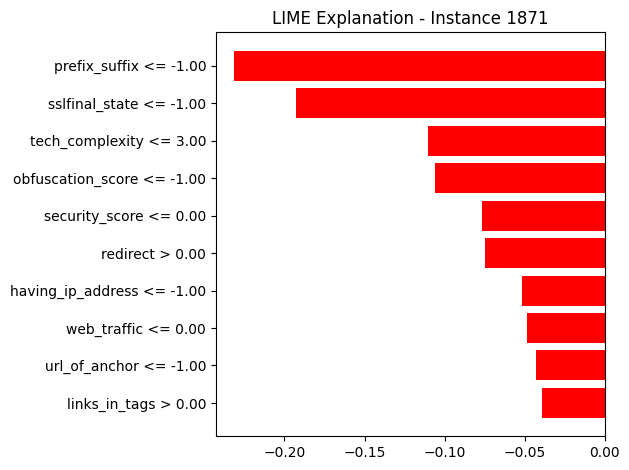

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



LIME Explanation for instance 1926:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


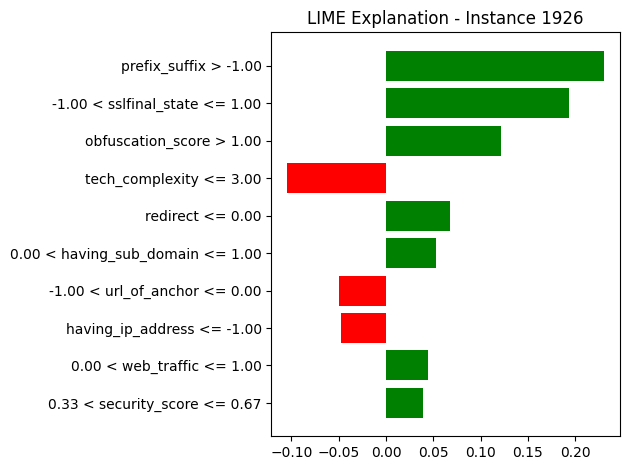

In [47]:
print("\n🔍 LIME Explanations - LSD Soft Voting Classifier")
for i, idx in enumerate(sample.index[:3]):
    instance = sample.loc[idx].values if isinstance(sample, pd.DataFrame) else sample.iloc[i]
    exp = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=soft_voting.predict_proba,
        num_features=10
    )
    print(f"\nLIME Explanation for instance {idx}:")
    exp.show_in_notebook()
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation - Instance {idx}")
    plt.tight_layout()
    plt.show()

# **Permutation Feature Importance**

Permutation Feature Importance
Top 5 Features by PFI:
             Feature  Importance
7     sslfinal_state    0.080256
13     url_of_anchor    0.076239
30  total_link_flags    0.036496
5      prefix_suffix    0.030769
33   tech_complexity    0.008632


<Figure size 1000x600 with 0 Axes>

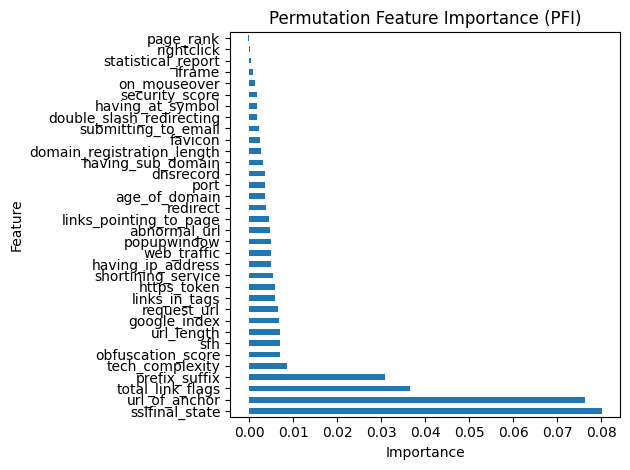

In [48]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
print("Permutation Feature Importance")
pfi_result = permutation_importance(soft_voting, X_test, y_test, n_repeats=10, random_state=42)
pfi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Top 5 Features by PFI:")
print(pfi_df.head())

plt.figure(figsize=(10, 6))
pfi_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Permutation Feature Importance (PFI)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# **PDP & ICE**

Feature sslfinal_state has 3 unique values: [ 0 -1  1]
Feature url_of_anchor has 3 unique values: [-1  0  1]
Feature total_link_flags has 9 unique values: [ 1 -1  2 -2  0  3 -3  4 -4]
Feature prefix_suffix has 2 unique values: [-1  1]
Feature tech_complexity has 11 unique values: [ 3  1 -5  5  4 -1 -3  2 -4 -2  0]


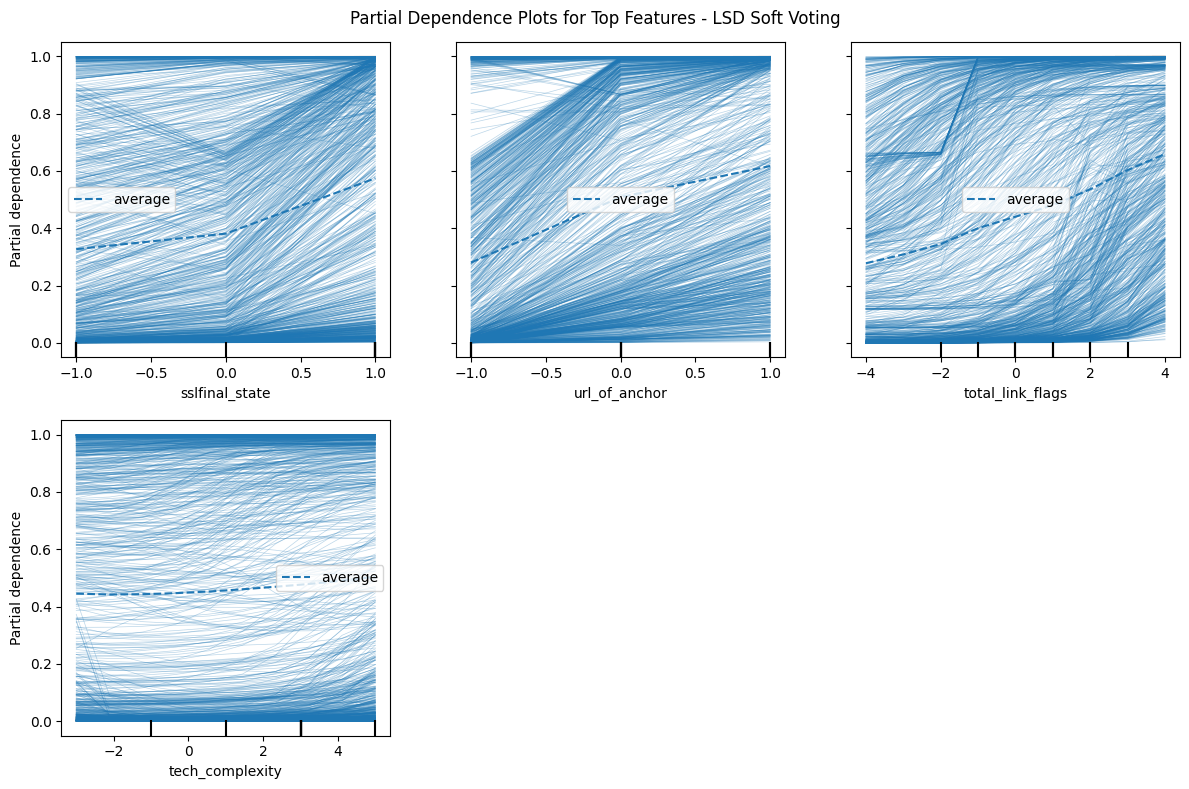

In [49]:
top_features = pfi_df['Feature'].head(5).tolist()

suitable_features = []
for feature in top_features:
    unique_values = X_test[feature].nunique()
    print(f"Feature {feature} has {unique_values} unique values: {X_test[feature].unique()}")
    if unique_values > 2:
        suitable_features.append(feature)

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    soft_voting,
    X_test,
    features=suitable_features,
    grid_resolution=10,
    kind ="both",
    ax=ax
)
plt.suptitle("Partial Dependence Plots for Top Features - LSD Soft Voting")
plt.tight_layout()
plt.show()

# **LOFO Importance**

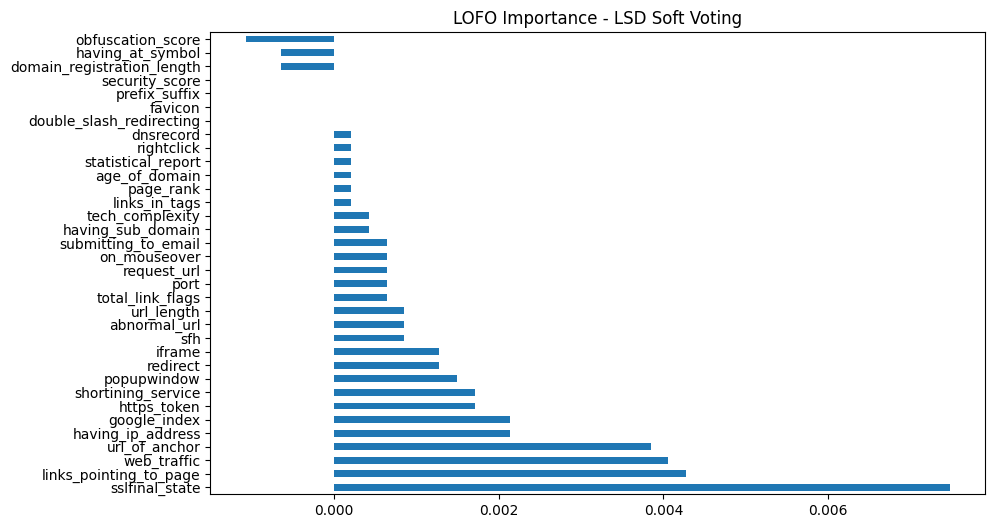

In [50]:
from sklearn.model_selection import cross_val_score
baseline= cross_val_score(soft_voting, X_train, y_train, cv=5).mean()

lofo_scores = {}
for col in X_train.columns:
    X_lofo = X_train.drop(col, axis=1)
    lofo_score = cross_val_score(soft_voting, X_lofo, y_train, cv=5).mean()
    lofo_scores[col] = baseline - lofo_score

lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - LSD Soft Voting")
plt.show()

In [51]:
print("\nTop 5 Features by LOFO Importance:")
print(lofo_df.head())


Top 5 Features by LOFO Importance:
sslfinal_state            0.007482
links_pointing_to_page    0.004276
web_traffic               0.004061
url_of_anchor             0.003848
having_ip_address         0.002138
dtype: float64
